In [2]:
from importlib import reload  # Python 3.4+
from numba import njit
import fibertools as ft
import pyranges as pr
import polars as pl
import pandas as pd
import mokapot
from fibertools.readutils import read_in_bed_file
from fibertools.utils import  join_msp_and_m6a
from fibertools.utils import n_overlaps
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from xgboost import XGBClassifier
from xgboost import plot_tree
import graphviz
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
import heapq
import os 
import sys
import pickle

np.random.seed(1)

sns.set_context("talk")
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi']= 300

def disjoint_bins(start, ends, spacer_size=0):
    h = []
    min_bin = 0
    heapq.heappush(h, (0, min_bin))

    bins = []
    for st,en in zip(start, ends):
        if st > h[0][0] + spacer_size:
            _old_en, b = heapq.heappop(h)
        else:
            min_bin += 1 
            b = min_bin
        heapq.heappush(h, (en, b))
        bins.append(b)
    return bins


def disjoint_bins_opt(start, ends, spacer_size=0):
    max_bin = 0
    min_starts = [(-spacer_size, max_bin)]
    bins = []
    for st,en in zip(start, ends):
        added = False
        for idx, (min_bin_st, b) in enumerate(min_starts):
            if st >= min_bin_st + spacer_size:
                min_starts[idx] = (en, b)
                bins.append(b)
                added = True
                break
        if not added:
            max_bin += 1
            min_starts.append( (en, max_bin) )
            bins.append(max_bin)
            
    return bins

def enable_log():
    logging.basicConfig(
        level=logging.INFO,
        format="%(levelname)s: %(message)s",
    )

def disable_log():
    logging.basicConfig(
        level=logging.WARNING,
        format="%(levelname)s: %(message)s",
    )

    
@njit
def find_nearest_index_old(array, values):
    array = np.asarray(array)
    idxs = []
    for val in values:
        idxs.append( (np.abs(array - val)).argmin())
    return np.array(idxs)

def find_nearest_q_values(orig_scores, orig_q_values, new_scores):
    orig_scores=np.flip(orig_scores)
    orig_q_values=np.flip(orig_q_values)
    idxs = np.searchsorted(orig_scores, new_scores, side="left")
    idxs[idxs >= len(orig_q_values)] = len(orig_q_values)-1 
    return np.array(orig_q_values)[idxs]


def make_percolator_input(msp_features_df, dhs_df, sort=True):
    """write a input file that works with percolator.

    Args:
        msp_features_df (_type_): _description_
        out_file (_type_): _description_

    return None
    """
    # need to add:   SpecId	Label ... Peptide Proteins
    dhs_null = n_overlaps(msp_features_df, dhs_df[dhs_df.name != "DHS"])
    dhs_true = n_overlaps(msp_features_df, dhs_df[dhs_df.name == "DHS"])

    out_df = msp_features_df.copy()
    
    out_df.insert(1, "Label", 0)
    out_df.loc[dhs_true > 0, "Label"] = 1
    out_df.loc[dhs_null > 0, "Label"] = -1
    # if the msp is short make it null
    out_df.loc[ (dhs_true > 0) & (out_df.msp_len <= args.min_tp_msp_len), "Label"] = -1
        
    condition = (dhs_null > 0) | (dhs_true > 0)
    
    if "SpecId" in out_df.columns:
        out_df.drop("SpecId", axis=1, inplace=True)
    out_df.insert(0, "SpecId", out_df.index)

    to_remove = ["ct", "st", "en", "fiber"]
    out_df.drop(to_remove, axis=1, inplace=True)

    out_df["Peptide"] = out_df.SpecId
    out_df["Proteins"] = out_df.SpecId
    out_df["scannr"] = out_df.SpecId
    out_df["log_msp_len"] = np.log(out_df["msp_len"])

    out_df.sort_values(["Label"], ascending=False, inplace=True)
    return out_df

def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

In [8]:
from dataclasses import dataclass

@dataclass
class Args:
    """Class for keeping track of an item in inventory."""
    msp_bed12: str = "../data/test_fiber_calls.bed.gz"
    m6a_bed12: str= "../data/test_fiber_m6A_calls.bed.gz"
    genome: str="../data/test.fa.gz"
    dhs: str="../data/dhs_with_null.bed.gz"
    min_tp_msp_len: int = 40
    #dhs: str="../tests/data/test_dhs_with_null.bed.gz"
    bin_width: int = 40
    bin_num: int = 9
    n_rows: int = None
    verbose: bool = False
    

args = Args()
log_format = "[%(levelname)s][Time elapsed (ms) %(relativeCreated)d]: %(message)s"
log_level = logging.DEBUG if args.verbose else logging.WARNING
#logging.basicConfig(format=log_format, level=log_level)

In [5]:
if False:
    df = join_msp_and_m6a(args)
    AT_genome = ft.make_AT_genome(args.genome, df)
    df["bin"] = disjoint_bins_opt(df.st, df.en, spacer_size=100)
    args.bin_num = 9
    msp_feat_9 = make_msp_features(args, df, AT_genome)
    logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.WARNING)
    dhs = read_in_bed_file(args.dhs, n_rows=args.n_rows)
    dhs = dhs[dhs.ct == "chr11"]
    pin = make_percolator_input(msp_feat_9, dhs)
    
    with open("indata.dat", "wb") as f:
        pickle.dump(pd.DataFrame(df.to_dicts()), f)
        pickle.dump(pin, f)
else:
    df, pin = list(loadall("indata.dat"))

FileNotFoundError: [Errno 2] No such file or directory: 'indata.dat'

In [110]:
#df = join_msp_and_m6a(args)
np.idxmax(df.fiber == "46924029/m54329U_210814_130637")

AttributeError: module 'numpy' has no attribute 'idxmax'

In [127]:
tmp = pd.read_csv("../tmp.bed.gz", sep="\t")
tmp.fiber.unique().shape

(100000,)

In [128]:
for fiber, g  in tmp.groupby("fiber"):
    pre_end = g.st.iloc[0]
    for st, en in zip(g.st, g.en):
        assert st == pre_end, g
        pre_end = en
    #print(g.st, g.en)
    #break

In [64]:
for row_n in range(1000):
    starts = list(np.array(df[row_n, "bst_msp"] + df[row_n, "st"]))
    ends = list(starts + np.array(df[row_n, "bsize_msp"]))
    real = list("a"*len(ends)) 
    y = ft.utils.null_space_in_bed12(df[row_n,])[["st","en"]]

    starts += list(y.st) 
    ends += list(y.en)
    real += list("b"*len(y.en))
    k=pd.DataFrame({"st":starts, "en":ends, "real":real}).sort_values("st")

    z = np.array(k.st[1:]) -np.array(k.en[:-1])
    nums = ((z==0 )| (z==-1 )).sum()
    if nums != z.shape[0]:
        print(z)
        print(k)

[nan]
         st        en real
0  179917.0  179951.0    a
1       NaN       NaN    b
[nan]
          st         en real
0  1939898.0  1939967.0    a
1        NaN        NaN    b


In [82]:
rows = pd.DataFrame(df.head().to_dicts())


,ct,st,en,fiber,score,strand_m6a,color_m6a,bct_m6a,bst_m6a,score_right,strand_msp,color_msp,bct_msp,bsize_msp,bst_msp
0,chr11,61015,83638,8390109/m54329U_210813_020940,4.38,.,"128,0,128",1099,"[29, 38, 42, 88, 187, 199, 202, 204, 207, 211,...",4.38,.,"128,0,128",119,"[14, 60, 75, 63, 73, 45, 49, 69, 43, 46, 8, 44...","[29, 199, 389, 568, 757, 945, 1122, 1321, 1524..."
1,chr11,61954,85766,50006165/m54329U_210814_130637,4.70,.,"128,0,128",1426,"[4, 6, 9, 14, 22, 27, 45, 50, 168, 169, 171, 1...",4.70,.,"128,0,128",122,"[47, 110, 80, 36, 113, 45, 43, 25, 31, 31, 53,...","[4, 168, 371, 580, 734, 959, 1144, 1323, 1508,..."
2,chr11,61981,85244,168953907/m54329U_210814_130637,4.03,.,"128,0,128",532,"[118, 244, 250, 263, 267, 274, 276, 278, 282, ...",4.03,.,"128,0,128",111,"[1, 80, 51, 55, 21, 1, 1, 75, 19, 6, 37, 1, 9,...","[118, 244, 449, 653, 858, 1083, 1244, 1435, 16..."
3,chr11,62030,83290,118686999/m54329U_210813_020940,3.10,.,"128,0,128",1463,"[159, 195, 199, 201, 225, 229, 234, 236, 237, ...",3.10,.,"128,0,128",109,"[116, 79, 76, 61, 44, 19, 83, 67, 41, 34, 1, 5...","[159, 397, 604, 817, 1034, 1229, 1385, 1573, 1..."
4,chr11,62051,80757,77988004/m54329U_210323_190418,3.97,.,"128,0,128",724,"[52, 58, 72, 74, 77, 79, 80, 84, 86, 88, 91, 9...",3.97,.,"128,0,128",99,"[92, 29, 35, 55, 35, 51, 74, 58, 71, 66, 22, 1...","[52, 251, 423, 639, 839, 1025, 1208, 1422, 163..."


In [4]:
must_drop = ['qValue','strand', 'tst', 'ten', 'color']
for col in must_drop:
    if col in pin.columns:
        pin.drop(col, axis=1, inplace=True)

train = pin[(pin.Label!=0) ].copy()#.sample(10_000) # & (pin.msp_len > 1)

In [5]:
min_size = 1
train_psms = mokapot.read_pin(train[train.msp_len >= min_size])
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)
grid = {
    "n_estimators": [25, 50, 100],
    "scale_pos_weight": [scale_pos_weight], #[0.5, 1, 2], #np.logspace(0, 2, 3),
    "max_depth": [3,6,9],
    "min_child_weight": [3, 6, 9],
    "gamma": [0.1, 1, 10],
}
xgb_mod = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric="auc"),
    param_grid=grid,
    cv=3,
    scoring="roc_auc",
    verbose=2,
)
mod = mokapot.Model(xgb_mod, train_fdr=0.1, subset_max_train=500_000) # override=True

In [7]:
pin

,SpecId,Label,score,fiber_m6a_count,fiber_AT_count,fiber_m6a_frac,msp_m6a,msp_AT,m6a_frac,msp_len,...,AT_count_3,AT_count_4,AT_count_5,AT_count_6,AT_count_7,AT_count_8,Peptide,Proteins,scannr,log_msp_len
15853029,15853029,1,7.44,244,4566,0.053438,25,83,0.301205,344,...,15,6,6,6,4,7,15853029,15853029,15853029,5.840642
2436027,2436027,1,3.38,547,14439,0.037884,22,60,0.366667,131,...,18,15,22,21,25,16,2436027,2436027,2436027,4.875197
13963345,13963345,1,5.99,941,5007,0.187937,17,25,0.680000,73,...,16,14,14,14,20,21,13963345,13963345,13963345,4.290459
7223230,7223230,1,4.65,708,8164,0.086722,63,119,0.529412,328,...,18,10,13,13,17,14,7223230,7223230,7223230,5.793014
8337719,8337719,1,4.48,384,6949,0.055260,25,65,0.384615,138,...,21,16,21,19,23,28,8337719,8337719,8337719,4.927254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15022973,15022973,-1,5.22,1168,12336,0.094682,2,6,0.333333,11,...,20,18,21,22,20,18,15022973,15022973,15022973,2.397895
8703278,8703278,-1,6.55,332,8672,0.038284,2,5,0.400000,13,...,21,19,27,23,24,21,8703278,8703278,8703278,2.564949
15022899,15022899,-1,4.31,805,9253,0.086999,6,15,0.400000,32,...,19,17,23,21,24,20,15022899,15022899,15022899,3.465736
11061678,11061678,-1,3.78,740,13570,0.054532,11,28,0.392857,57,...,23,17,25,24,24,27,11061678,11061678,11061678,4.043051


In [12]:
if False:
    moka_conf, models = mokapot.brew(train_psms, mod, test_fdr=0.05)
    with open("models.dat", "wb") as f:
        pickle.dump(moka_conf.psms, f)
        pickle.dump(models, f)
else:
    moka_conf_psms, models = list(loadall("models.dat"))

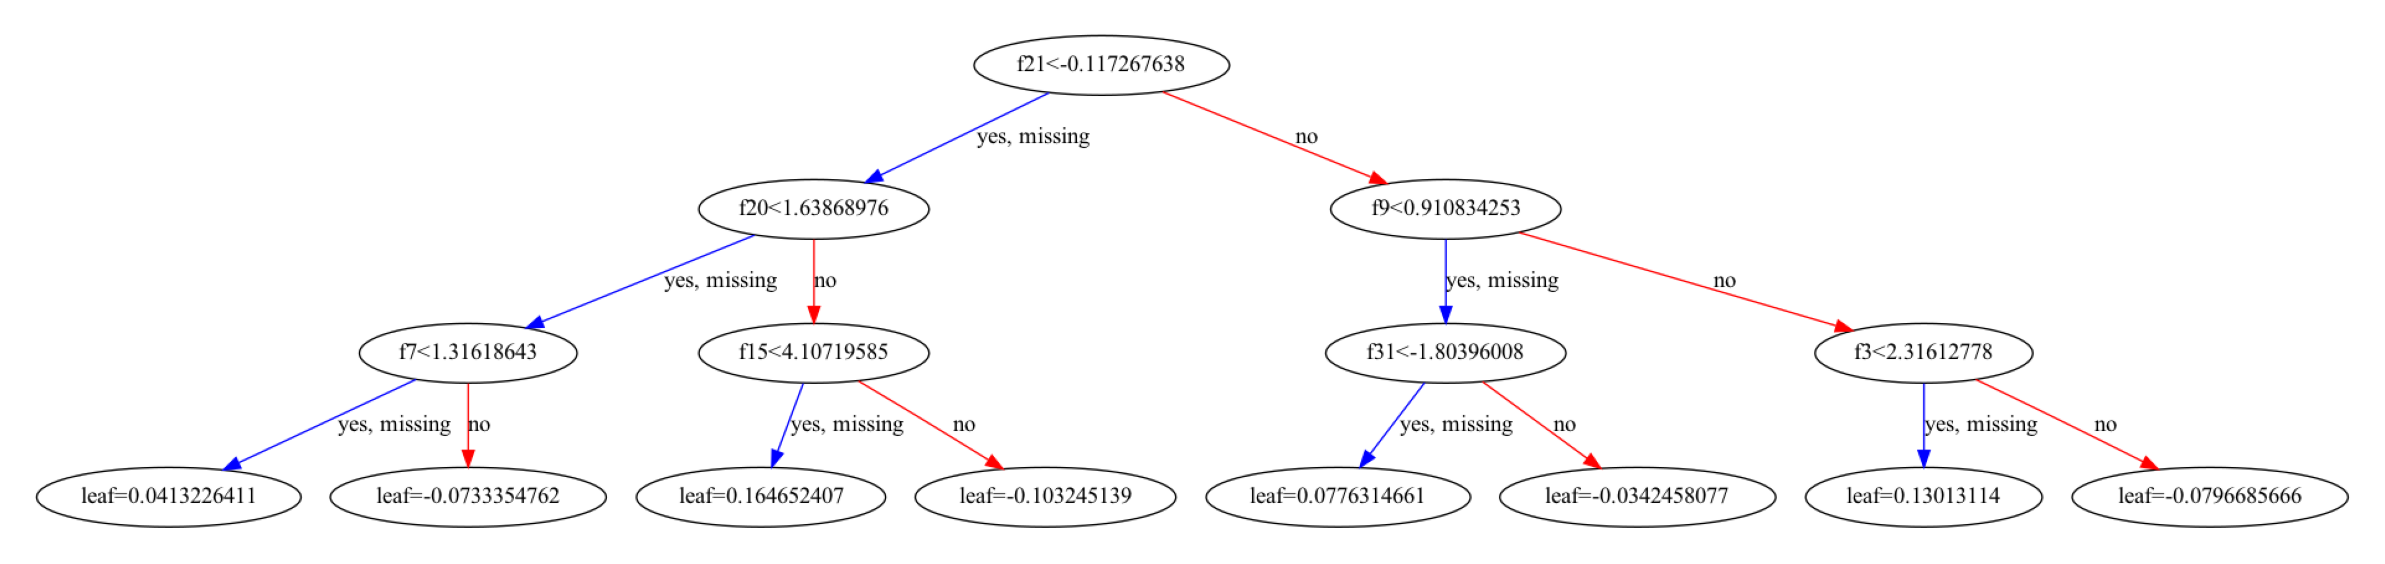

In [15]:
# plot single tree
plot_tree(models[0].estimator, num_trees=50)
plt.show()
#list(zip(models[0].features, range(len(models[0].features))))

205655.0

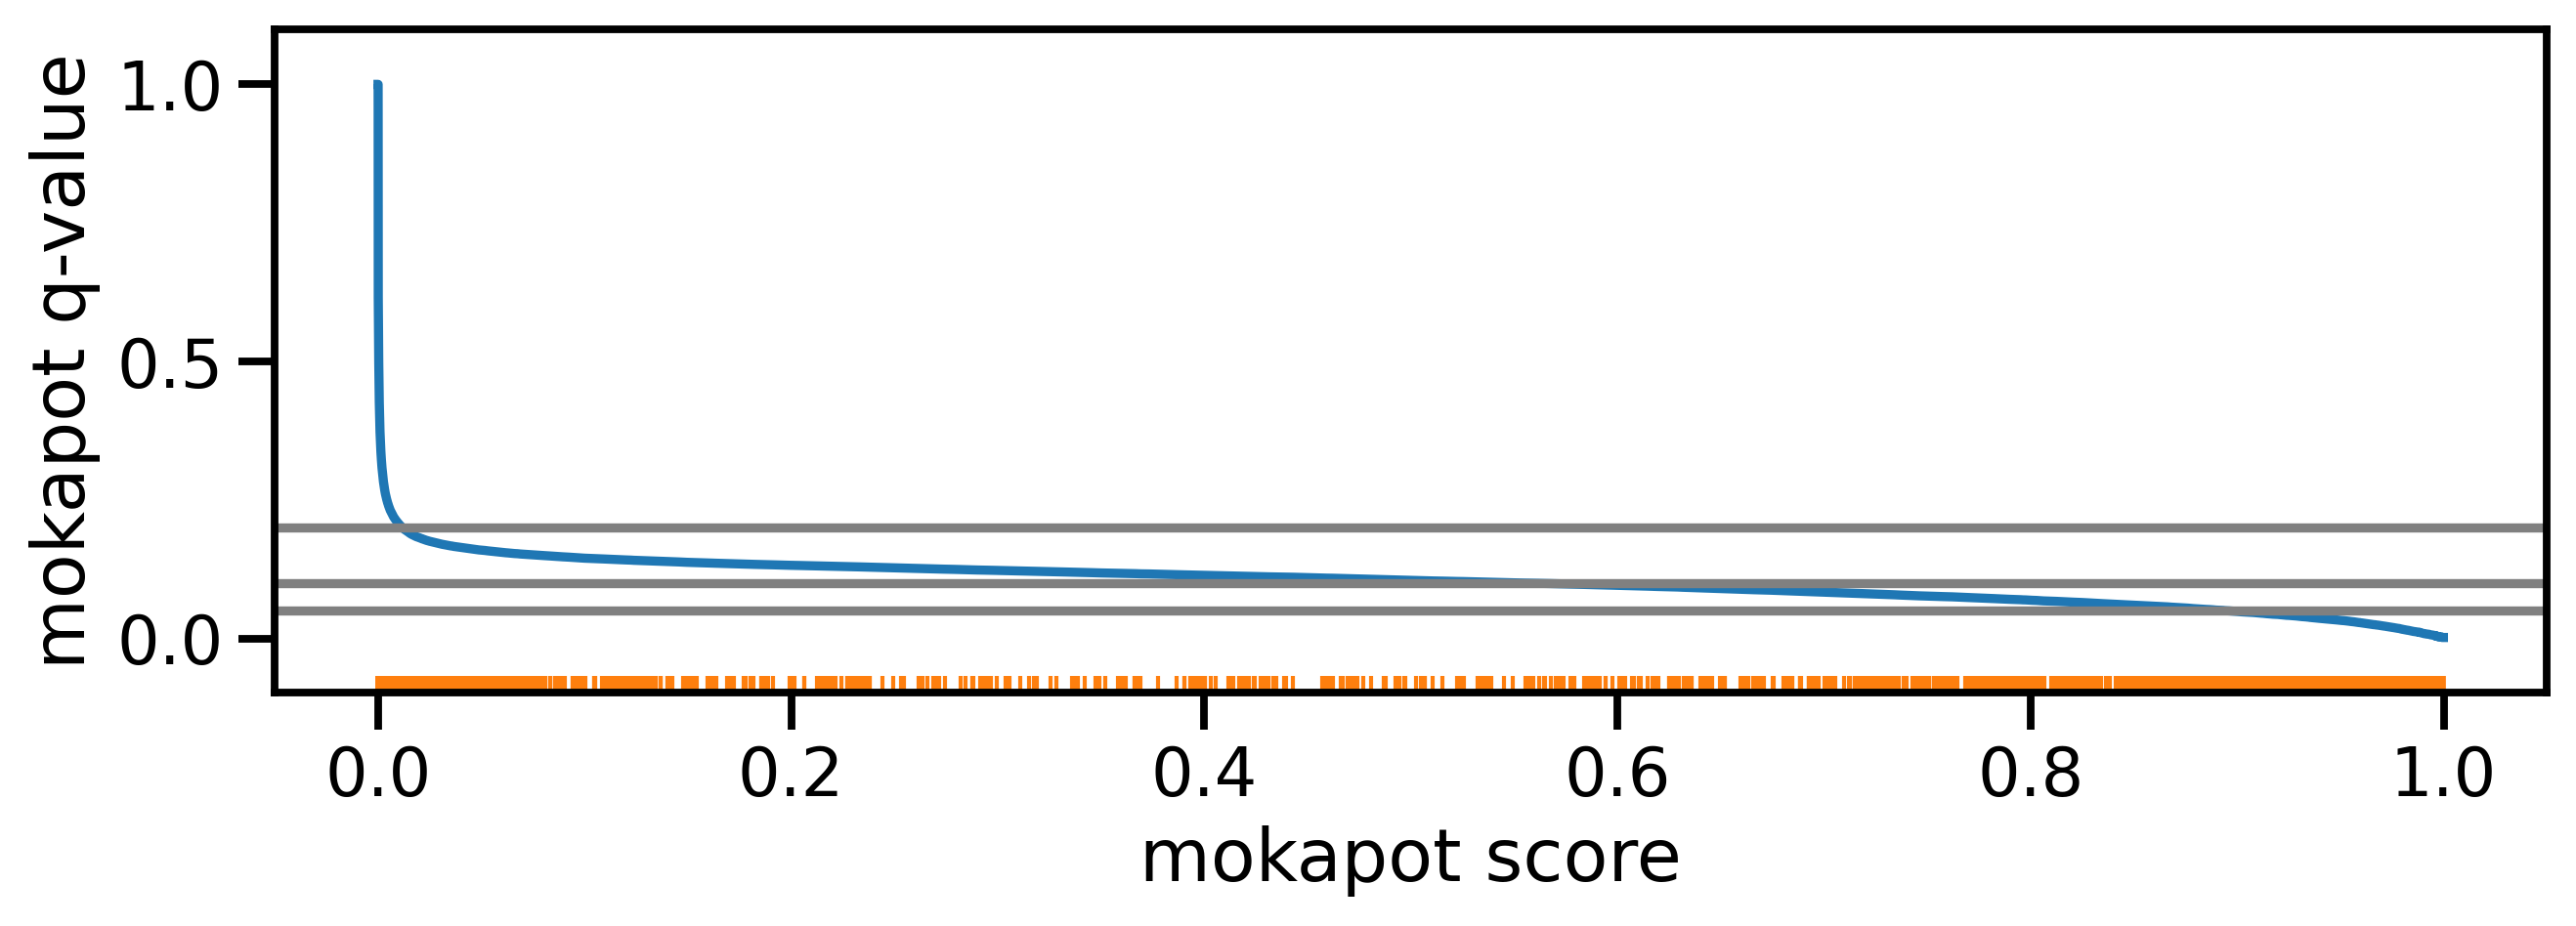

In [ ]:
graph = sns.lineplot(data=moka_conf_psms.sample(5000), x="mokapot score", y ="mokapot q-value")
graph.axhline(0.05, color="gray")
graph.axhline(0.10, color="gray")
graph.axhline(0.20, color="gray")
sns.rugplot(data=moka_conf_psms.sample(5000), x="mokapot score")
train.shape[0]/2

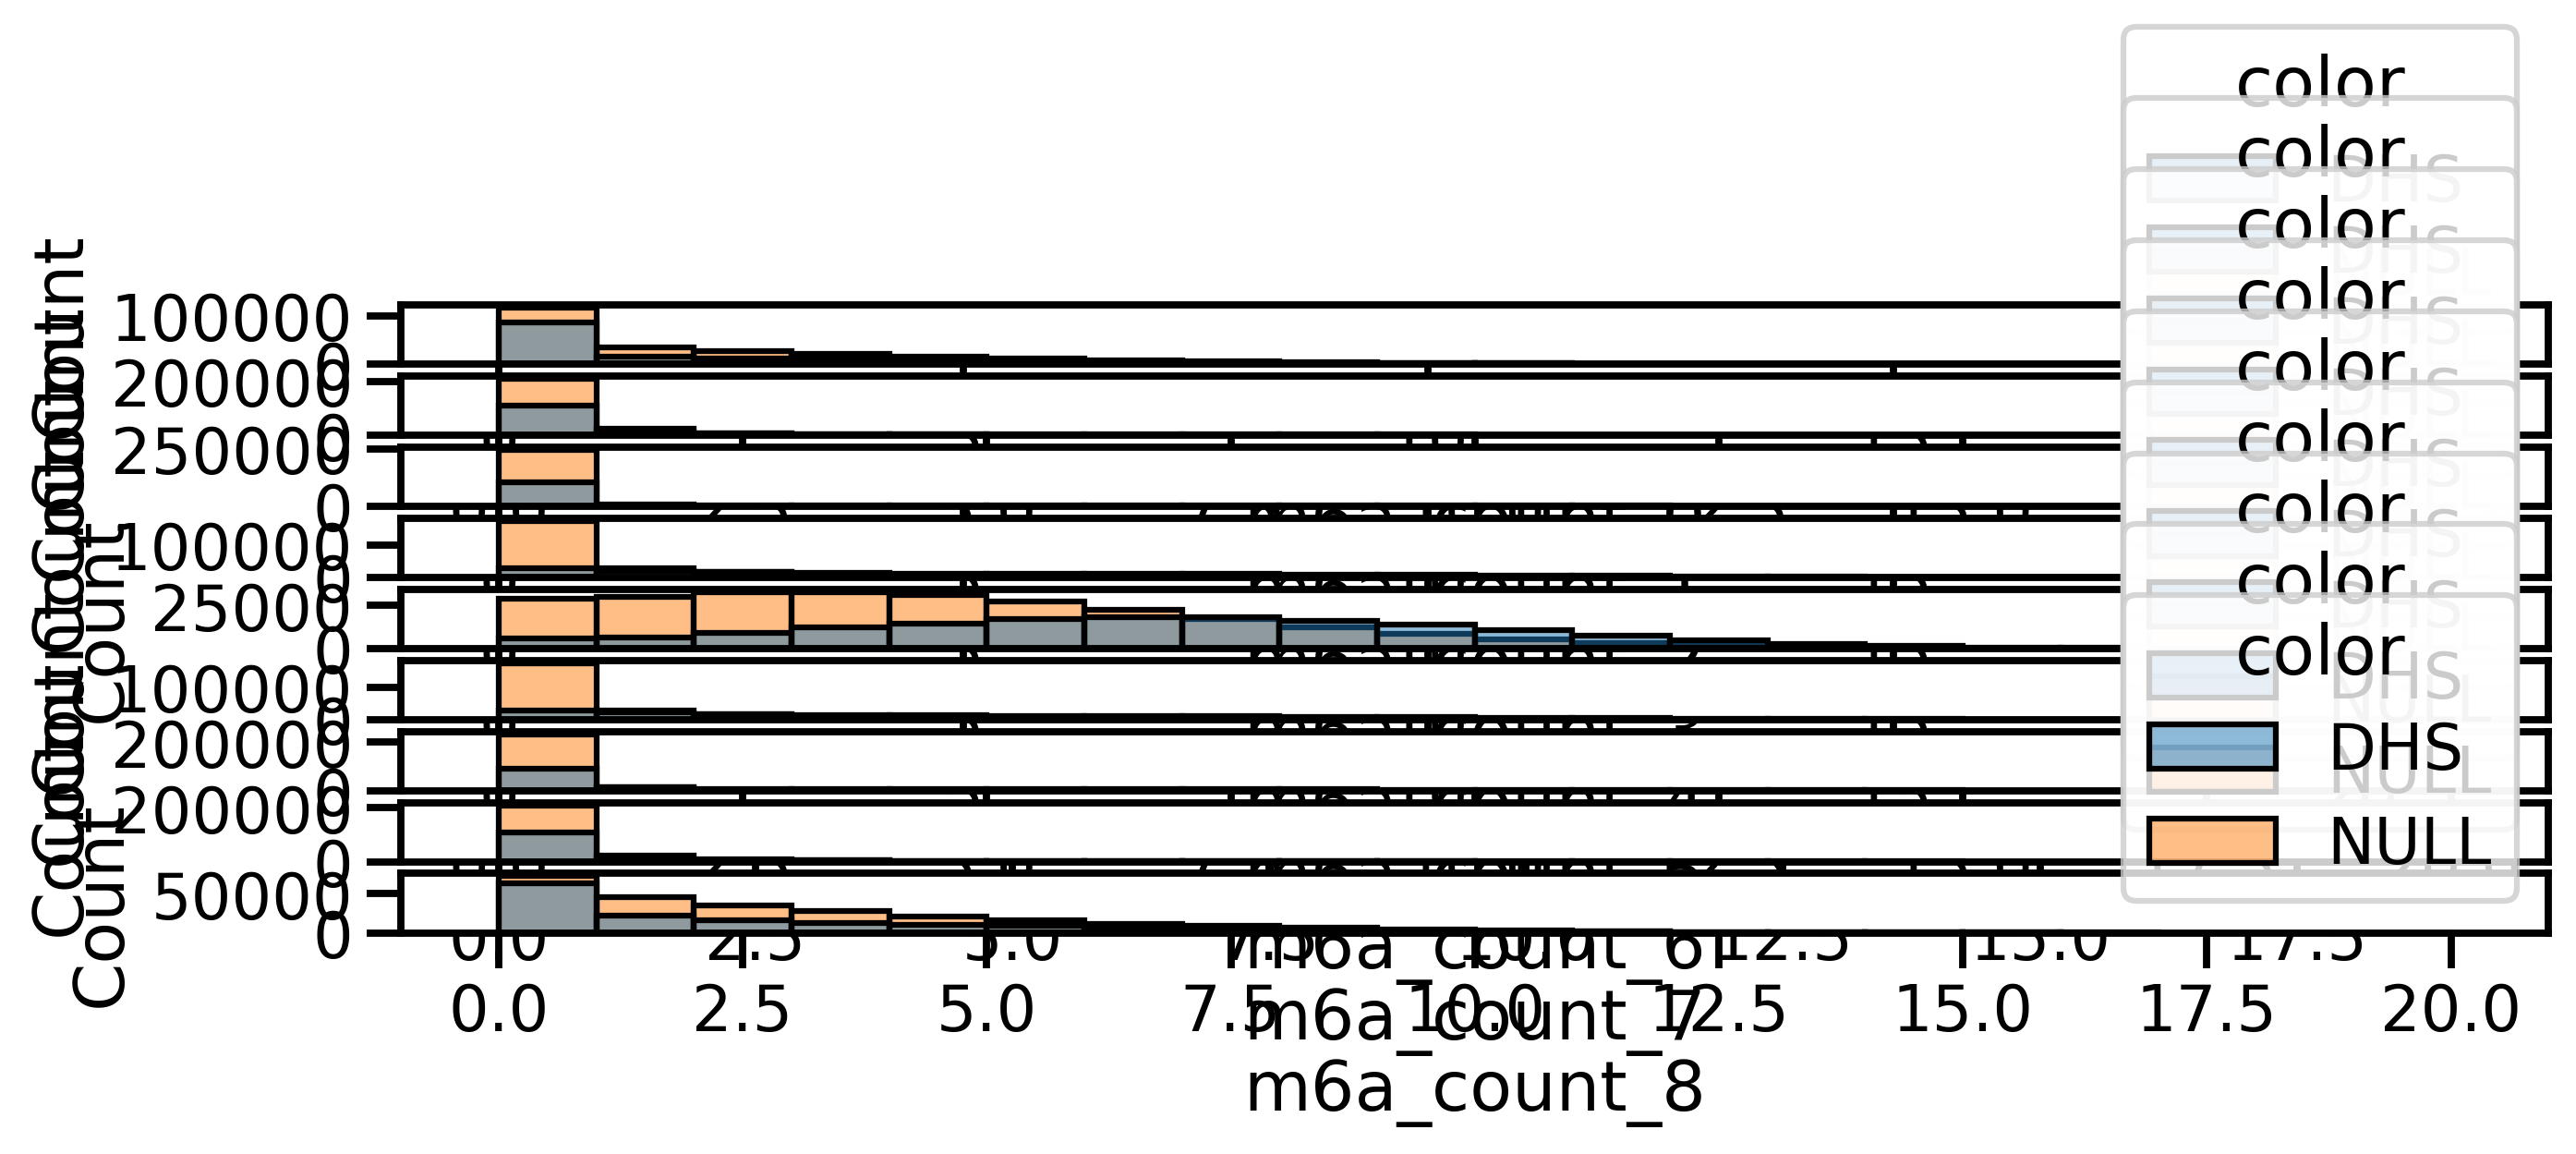

In [9]:
n=args.bin_num
p, ax = plt.subplots(n,1)
train["color"] = "NULL"
train.loc[train.Label == 1, "color"] = "DHS"
for i in range(n):
    sns.histplot(data=train, x=f"m6a_count_{i}", hue="color", bins=20, ax = ax[i])

In [16]:
test_psms = mokapot.read_pin(pin)
all_scores = [model.predict(test_psms) for model in models]

In [17]:
scores = np.mean(np.array(all_scores), axis=0)
#scores = np.amin(np.array(all_scores), axis=0)
#scores = np.amax(np.array(all_scores), axis=0)

q_values = find_nearest_q_values(
    moka_conf_psms["mokapot score"],
    moka_conf_psms["mokapot q-value"],
    scores
)
merged = pin.copy()
merged["mokapot score"] = scores
merged["mokapot q-value"] = q_values
merged.shape

(15853030, 43)

In [27]:
(np.amax(np.array(all_scores), axis=0) < 0.05).sum()/1e6, (np.amin(np.array(all_scores), axis=0) < 0.05).sum()/1e6, (np.mean(np.array(all_scores), axis=0) < 0.05).sum()/1e6

(14.786432, 15.218227, 14.916957)

In [ ]:
FDR = 0.10
out_col = f"Predicted accessible, FDR < {FDR}"
merged[out_col] = merged["mokapot q-value"] < FDR
#merged.groupby(out_col).describe(include = "all").transpose().loc[["m6a_frac", "msp_len"]]
merged[out_col].value_counts()

False    15407842
True       445188
Name: Predicted accessible, FDR < 0.1, dtype: int64

In [18]:
sample_n = 10_000
tmp = (merged
       .query("msp_len > 1")
       .groupby(out_col)
       .apply(lambda x: x.sample(sample_n))
)

sns.kdeplot(
    data=tmp,
    y="msp_len",
    x="m6a_frac",
    hue=out_col,
    #hue = "mokapot q-value",
    thresh=.1,
    log_scale=[False, True]
)

NameError: name 'out_col' is not defined

In [ ]:
merged["x"]=merged["mokapot q-value"].rank()

fig, ax = plt.subplots()
sns.ecdfplot(
    data = merged, #merged[merged["mokapot q-value"] < 0.1],
    x="mokapot q-value",
    ax=ax
)
max_x = 1
max_y = (merged["mokapot q-value"] < max_x).sum()/merged.shape[0]
#ax.set_xlim(0, max_x)
#ax.set_ylim(0, max_y*1.01)
plt.show()


In [20]:
pin.columns

Index(['SpecId', 'Label', 'score', 'fiber_m6a_count', 'fiber_AT_count',
       'fiber_m6a_frac', 'msp_m6a', 'msp_AT', 'm6a_frac', 'msp_len',
       'm6a_frac_0', 'm6a_frac_1', 'm6a_frac_2', 'm6a_frac_3', 'm6a_frac_4',
       'm6a_frac_5', 'm6a_frac_6', 'm6a_frac_7', 'm6a_frac_8', 'm6a_count_0',
       'm6a_count_1', 'm6a_count_2', 'm6a_count_3', 'm6a_count_4',
       'm6a_count_5', 'm6a_count_6', 'm6a_count_7', 'm6a_count_8',
       'AT_count_0', 'AT_count_1', 'AT_count_2', 'AT_count_3', 'AT_count_4',
       'AT_count_5', 'AT_count_6', 'AT_count_7', 'AT_count_8', 'Peptide',
       'Proteins', 'scannr', 'log_msp_len'],
      dtype='object')

<AxesSubplot:xlabel='m6a_frac', ylabel='msp_len'>

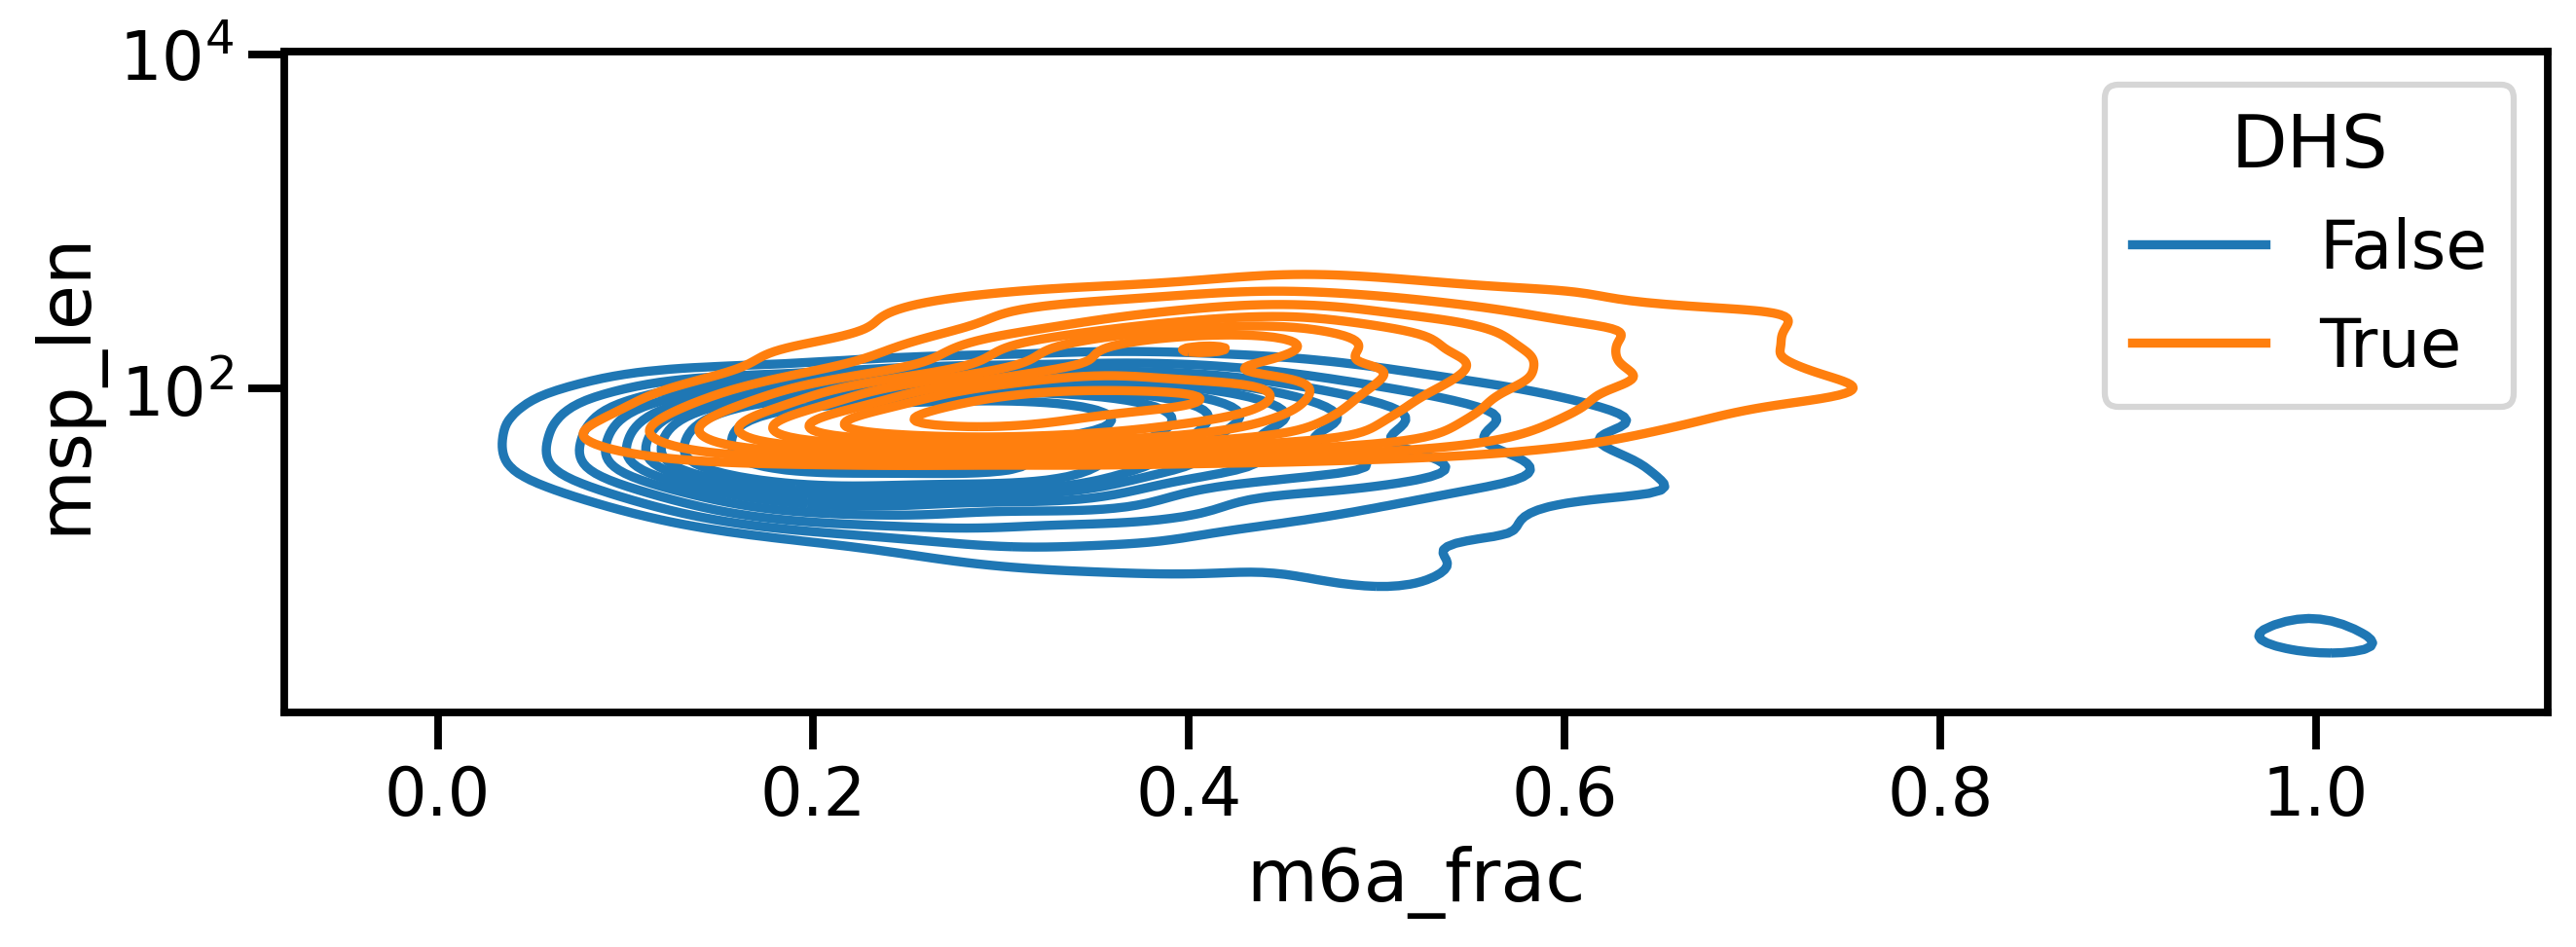

In [ ]:
tmp = pin.loc[pin.Label != 0].sample(sample_n).copy()
tmp["DHS"] = tmp.Label > 0
sns.kdeplot(
    data=tmp.query("msp_len > 1"),
    y="msp_len",
    x="m6a_frac",
    hue="DHS",
    thresh=.1,
    log_scale=[False, True]
)

In [19]:
out=pin.copy()#msp_feat_9
out["qValue"] = 1
out["strand"] = "+"
out.loc[merged.SpecId,"qValue"] = merged["mokapot q-value"]
out["tst"] = out["st"]
out["ten"] = out["en"]
out["color"] = "147,112,219"
#out.loc[ out.qValue < 0.5, "color"] =  "255,255,0"
#out.loc[ out.qValue < 0.4, "color"] =  "255,255,0"
out.loc[ out.qValue < 0.3, "color"] =  "255,255,0"
out.loc[ out.qValue < 0.2, "color"] =  "255,140,0"
out.loc[ out.qValue < 0.1, "color"] =  "255,0,0"
out.loc[ out.qValue < 0.05, "color"] =  "139,0,0"
out = out.merge(df[["fiber", "bin"]])

KeyError: 'st'

In [ ]:
rows=df
rows["spacer_st"] = rows.apply(lambda row: (row["bst_msp"]+row["bsize_msp"])[:-1] + row["st"], axis=1)
rows["spacer_en"] = rows.apply(lambda row: row["bst_msp"][1:] + row["st"] + 1, axis=1)
z = rows.explode(["spacer_st","spacer_en"])
z["qValue"] = 1
z["strand"] = "+"
z["tst"] = z["spacer_st"]
z["ten"] = z["spacer_st"] # make non msp thin blocks
z["color"] = "230,230,230"
z.drop(columns=['st', 'en'], inplace=True)
z.rename(columns={"spacer_st":"st", "spacer_en":"en"}, inplace=True)

In [ ]:
outcols = ['ct', 'st', 'en', 'fiber', 'score', "strand", "tst", "ten", "color", 'qValue', 'bin']
final_out = (pd.concat([
        out[outcols],
        z[outcols]
    ])
 .sort_values(["ct", "st"])
 .rename(columns={"ct":"#ct"})
)
final_out["score"] = (final_out.qValue*100).astype(int)

In [ ]:
final_out.to_csv("/Users/mrvollger/Desktop/tmp.tbl.gz", 
         sep="\t",
         index=False, 
         compression="gzip"
        )

In [ ]:
ODIR="/Users/mrvollger/Desktop/repos/fibertools/tmp"
os.makedirs(f"{ODIR}/", exist_ok=True)

for cur_bin in sorted(final_out.bin.unique()):
    sys.stderr.write(f"\r{cur_bin}")
    (final_out
         .loc[final_out.bin == cur_bin]
         .to_csv(f"{ODIR}/bin.{cur_bin}.bed.gz", 
                 sep="\t",
                 index=False, 
                 compression="gzip"
                )
    )

133

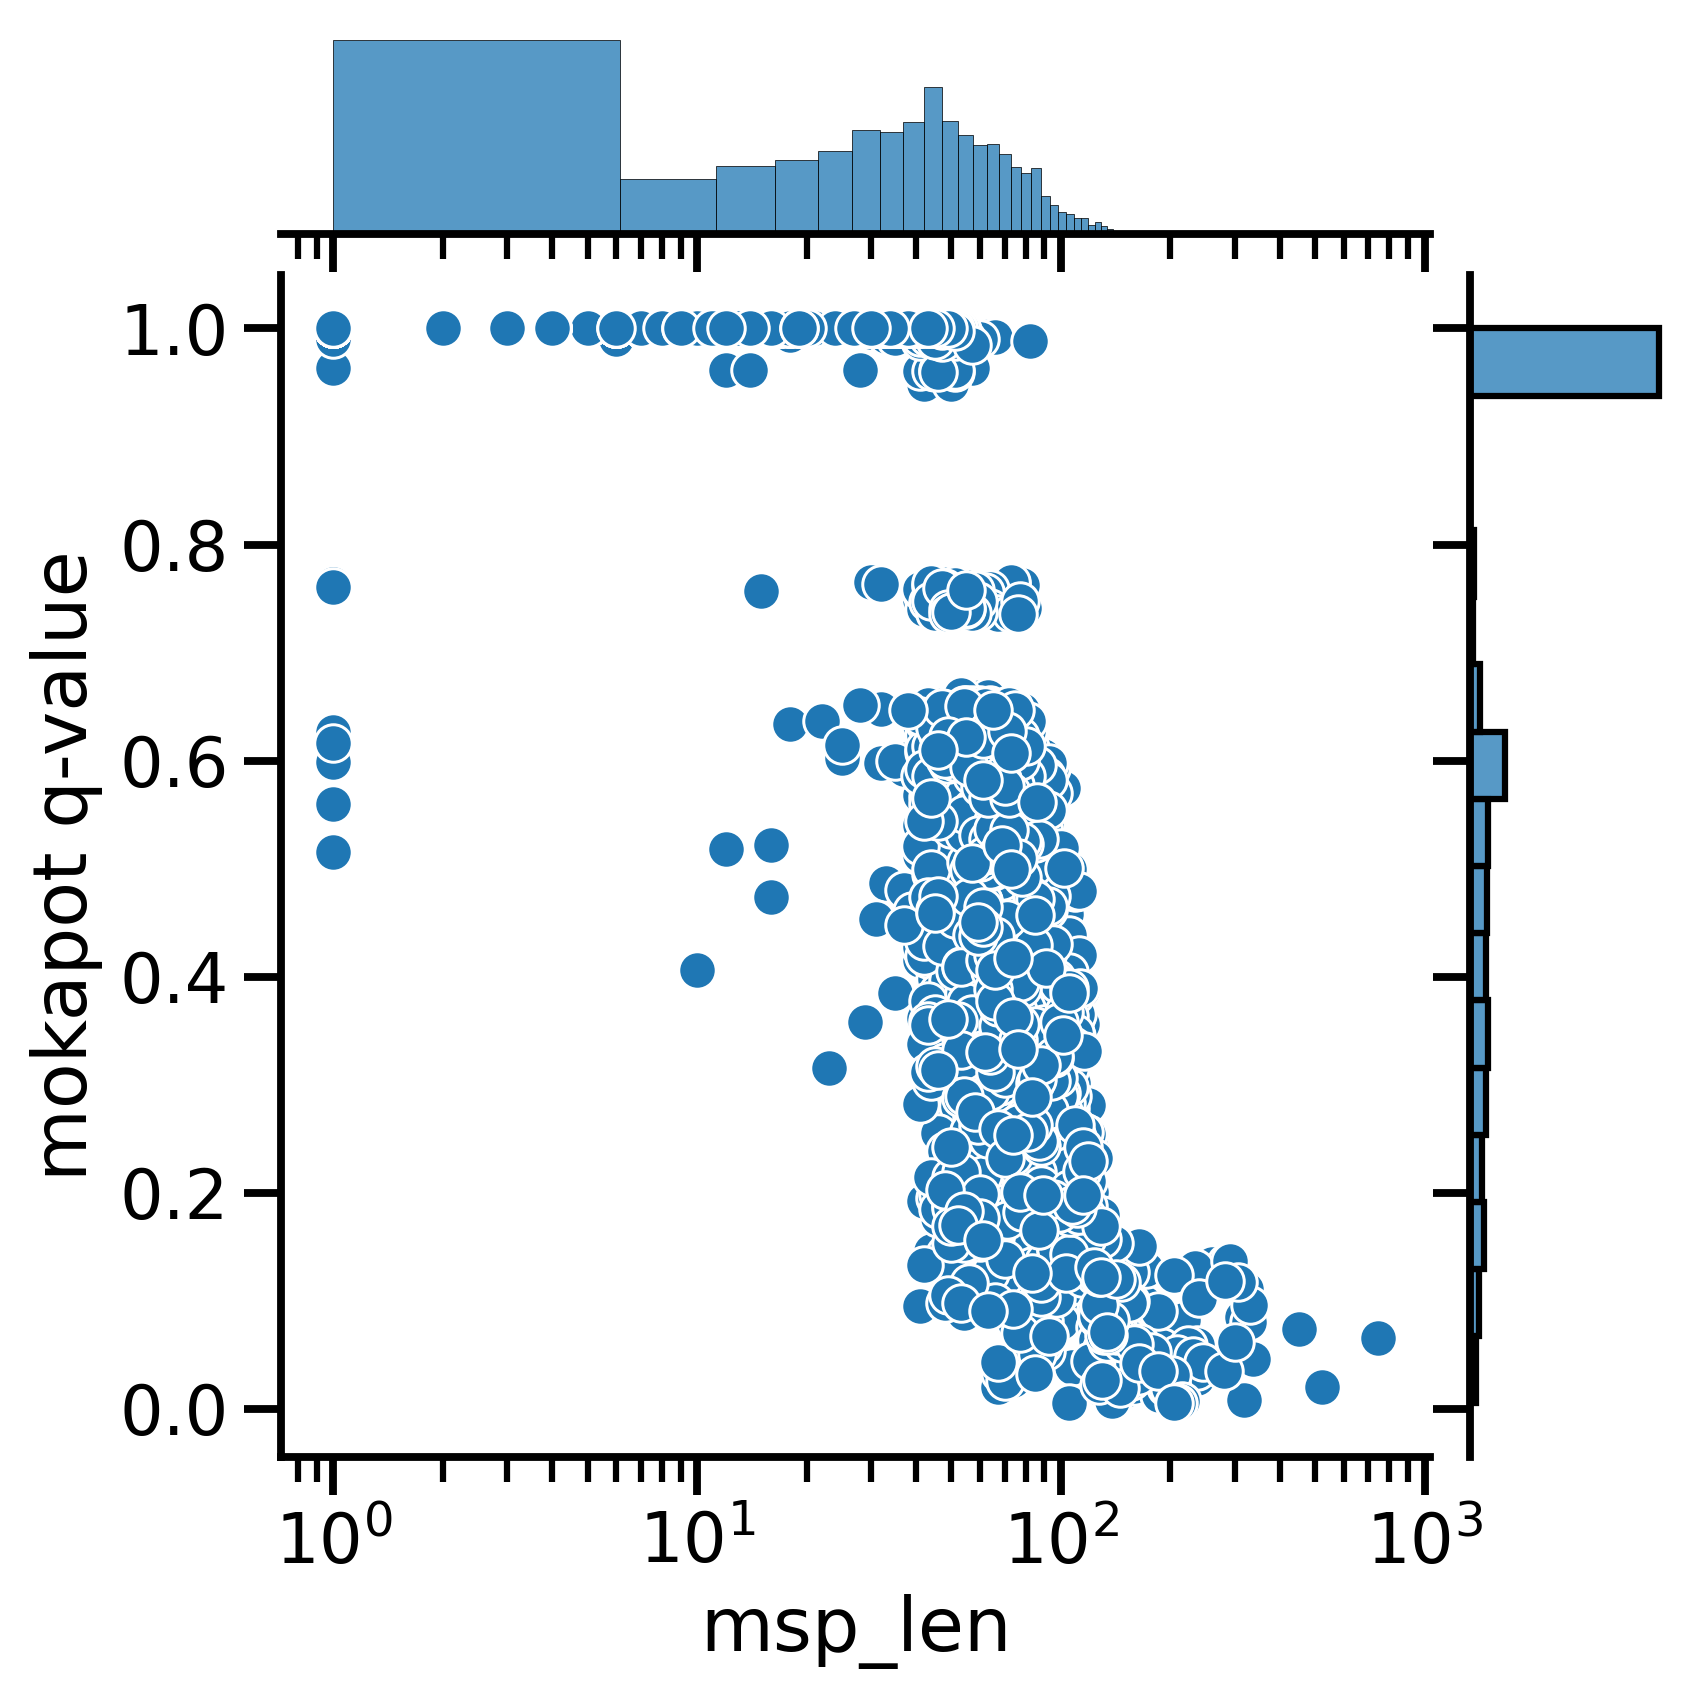

In [ ]:
g=sns.jointplot(
    data=merged.sample(5000),
    x="msp_len",
    y="mokapot q-value",
    #thresh=.1,
    #log_scale=[True, False],
   # logx=True,
    #kind="hex"
)
g.ax_joint.set_xscale('log')
g

In [ ]:
df[df.fiber == "89917773/m54329U_210813_020940"]
final_out[final_out.fiber == "89917773/m54329U_210813_020940"].bin.unique()

array([1])

In [ ]:
"89917773/m54329U_210813_020940" == "89917773/m54329U_210813_020940"

True

In [ ]:
df[df.fiber == "89917773/m54329U_210813_020940"].bin


3925    1
Name: bin, dtype: int64

In [33]:
import numpy as np
np.array_split(df.index, 2)

[Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             99484, 99485, 99486, 99487, 99488, 99489, 99490, 99491, 99492,
             99493],
            dtype='int64', length=99494),
 Int64Index([ 99494,  99495,  99496,  99497,  99498,  99499,  99500,  99501,
              99502,  99503,
             ...
             198977, 198978, 198979, 198980, 198981, 198982, 198983, 198984,
             198985, 198986],
            dtype='int64', length=99493)]